In [12]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import siuba as s
from siuba import _

%run -i 'model_helpers.py'
%run -i 'models.py'

In [18]:
df = pd.read_csv("data/exp1.csv")

df = df >> s.filter(_.pass_check==1) >> s.mutate(response = _.response.replace({0:.01, 1:.99}))
df = (df >> 
    s.mutate(
        condition = s.case_when({
            _.condition=="coldrainy_london": 0,
            _.condition=="sunnywarm_london": 1,
            _.condition=="coldrainy_LA": 2,
            _.condition=="sunnywarm_LA": 3
        })
    )
)

print(df.shape)
df.head()

(7680, 13)


,ID,age,gender,race,zip,StartDate,duration,pass_check,response,querytype,weather_cond,location_cond,condition
0,1,53,Man,White,72088.0,2021-05-10T13:52:06Z,617,1,0.7,A,coldrainy,london,0
1,2,27,Woman,White,28390.0,2021-05-10T13:59:41Z,1075,1,0.2,A,coldrainy,london,0
2,3,28,Man,White,10956.0,2021-05-10T14:12:27Z,543,1,0.5,A,coldrainy,london,0
3,4,32,Man,White,56187.0,2021-05-10T14:15:45Z,805,1,0.5,A,coldrainy,london,0
4,5,31,Man,White,66021.0,2021-05-10T14:22:09Z,491,1,0.7,A,coldrainy,london,0


In [20]:
df_test = df >> s.filter(_.ID < 11)
X_data, y_data = make_model_data(df_test) # see data_helpers.py
print(len(y_data))

800


# Relative Frequency model


In [21]:
def calc_prob(theta, X_num, X_denom):

    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    
    return jnp.divide(numerator, denom)

def relative_freq(data, y=None):

    rounded_to = .1
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
        
    pi = calc_prob(theta, X_num, X_denom)

    with numpyro.plate("data", len(trial)):
        # accounting for rounding
#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_err = (y_err - .50)*rounded_to

#         y_true = numpyro.sample("y_true", dist.Beta(pi*k, (1-pi)*k))
#         numpyro.sample("y_hat", dist.Normal(y_true + y_err, .0001), obs=y)
        
        # not accounting for rounding
        yhat = numpyro.sample("yhat", dist.Beta(pi*k, (1-pi)*k), obs=y)

In [22]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.80), 
               num_warmup=500, 
               num_samples=500, 
               num_chains=1)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 1000/1000 [03:17<00:00,  5.06it/s, 1023 steps of size 7.88e-04. acc. prob=0.82]


In [ ]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py


<ipython-input-25-a45488b531d2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat #


Participant mean response corr =  0.575
Query-level corr 0.669


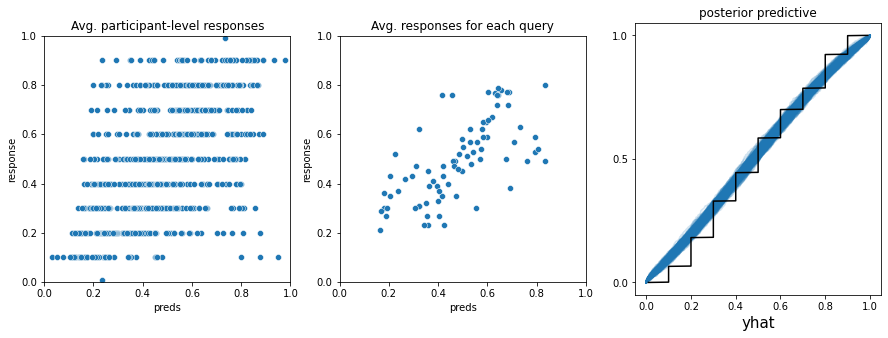

In [25]:
def plot_model_preds(orig_data, model_data):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_xlim(0,1)
    axes[1].set_xlim(0,1)
    axes[0].set_ylim(0,1)
    axes[1].set_ylim(0,1)
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
#     fig.suptitle('Model')

    d = orig_data
    d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat # 
    print("Participant mean response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
    sns.scatterplot(ax = axes[0], x = d.preds, y = d.response)

    trial_df = (d
                .groupby(["querytype", "condition"])
                .agg({"preds":"mean", "response":"mean"})
               )
    print("Query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
    sns.scatterplot(ax = axes[1], x = trial_df.preds, y = trial_df.response)
    az.plot_ppc(ax=axes[2], data=model_data, data_pairs={"yhat":"yhat"}, kind="cumulative", num_pp_samples=500, legend=False)
    axes[0].set_title("Avg. participant-level responses")    
    axes[1].set_title("Avg. responses for each query")
    axes[2].set_title("posterior predictive")
    
plot_model_preds(df_test, az_data_rf)

# Bayesian sampler model


In [29]:

def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


def bayesian_sampler_simple(data, y=None):

    rounded_to = .1
    
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(50)) # noise parameter

    with numpyro.plate("subj", n_Ps):
        ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    d_lin = ds[subj]
    d = sigmoid(d_lin)/3.
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
#         y_err = numpyro.sample("y_err", dist.Beta(1,1))
#         y_err = (y_err - .50)*rounded_to
        
#         true_obs = y + y_err if y is not None else None
#         yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=true_obs)
        
        # y_true = p_bs
        # y_true = numpyro.sample("y_true", dist.Beta(p_bs*k, (1-p_bs)*k))
        # yhat = numpyro.sample("yhat", dist.StudentT(3, y_true + y_err, .001), obs=y)
        
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [ ]:
from numpyro.infer.initialization import init_to_value, init_to_feasible

mcmc_bs_simple = MCMC(NUTS(bayesian_sampler_simple, target_accept_prob=.80), 
               num_warmup=500, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [6]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py

In [28]:
print("num divergences =", count_divergences(az_data_bs_simple))
az.summary(az_data_bs_simple, var_names=['d_base', 'k'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


num divergences = 1000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base[0],0.439,0.057,0.325,0.499,0.041,0.035,3.0,11.0,NaN
d_base[1],-0.417,0.102,-0.506,-0.216,0.080,0.074,2.0,20.0,NaN
d_base[2],0.578,0.161,0.275,0.732,0.124,0.111,3.0,12.0,NaN
d_base[3],0.483,0.051,0.399,0.570,0.033,0.027,3.0,19.0,NaN
d_base[4],0.002,0.028,-0.036,0.071,0.012,0.013,5.0,13.0,NaN
...,...,...,...,...,...,...,...,...,...
d_base[92],-0.316,0.147,-0.465,-0.099,0.134,0.146,1.0,12.0,NaN
d_base[93],0.124,0.012,0.108,0.158,0.003,0.002,17.0,16.0,NaN
d_base[94],0.091,0.063,0.001,0.208,0.049,0.043,2.0,20.0,NaN
d_base[95],0.505,0.050,0.418,0.562,0.041,0.039,2.0,48.0,NaN


Participant mean response corr =  0.254
Query-level corr 0.341


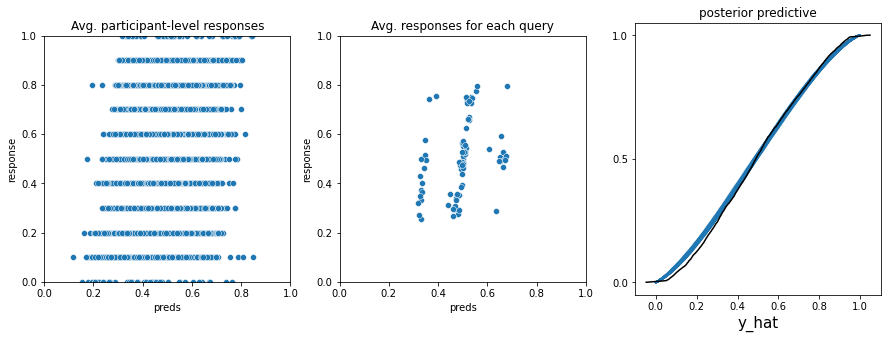

In [8]:
def plot_model_preds(orig_data, model_data):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_xlim(0,1)
    axes[1].set_xlim(0,1)
    axes[0].set_ylim(0,1)
    axes[1].set_ylim(0,1)
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
#     fig.suptitle('Model')

    d = orig_data
    d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat # 
    print("Participant mean response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
    sns.scatterplot(ax = axes[0], x = d.preds, y = d.response)

    trial_df = (d
                .groupby(["querytype", "condition"])
                .agg({"preds":"mean", "response":"mean"})
               )
    print("Query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
    sns.scatterplot(ax = axes[1], x = trial_df.preds, y = trial_df.response)
    az.plot_ppc(ax=axes[2], data=model_data, data_pairs={"yhat":"yhat"}, kind="cumulative", num_pp_samples=500, legend=False)
    axes[0].set_title("Avg. participant-level responses")    
    axes[1].set_title("Avg. responses for each query")
    axes[2].set_title("posterior predictive")

plot_model_preds(df, az_data_bs_simple)

In [92]:
az_data_bs_simple

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Complex

In [29]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.679
Query-level corr 0.849


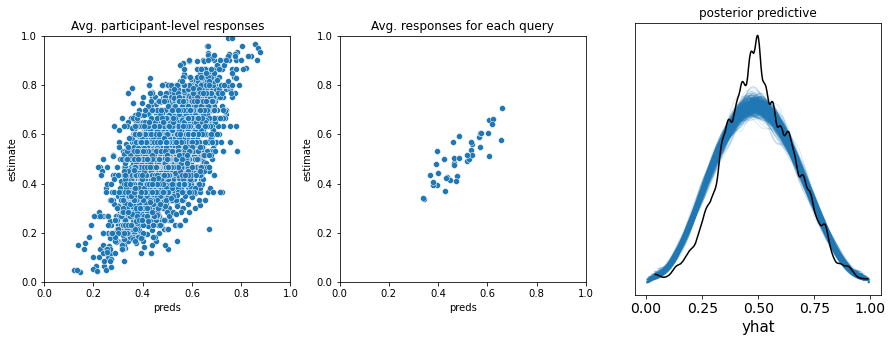

In [30]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs)

# Probability theory plus noise (PT+N) model

### Simple

In [15]:
mcmc_ptn_simple = MCMC(NUTS(PTN_simple, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.62
Query-level corr 0.778


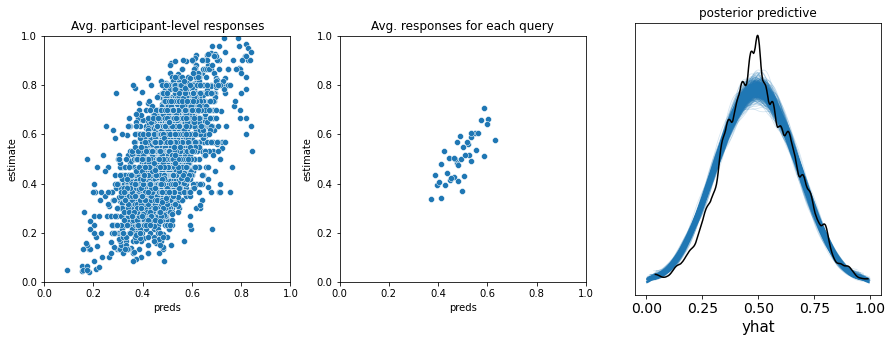

In [16]:
az_data_ptn_simple = make_arviz_data(mcmc_ptn_simple, PTN_simple, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_simple)

### Complex

In [17]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
# mcmc_ptn.print_summary()

Participant mean response corr =  0.668
Query-level corr 0.841


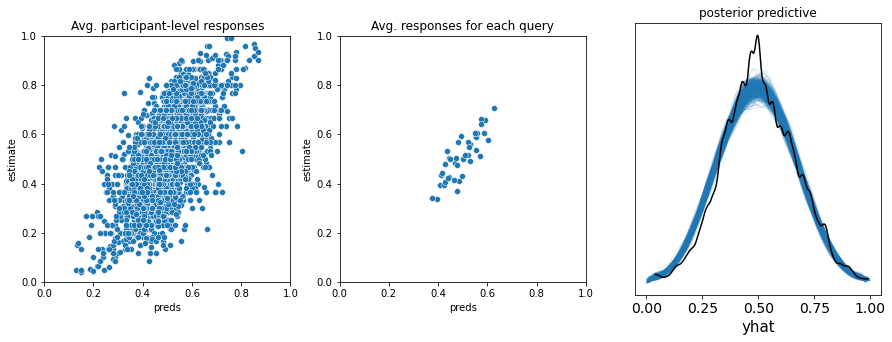

In [19]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn)

In [35]:
az.compare(
    {
        "P+TN complex":az_data_ptn, 
        "Bayesian Sampler complex": az_data_bs, 
        "P+TN simple":az_data_ptn_simple, 
        "Bayesian Sampler simple": az_data_bs_simple, 
        "Relative Freq.":az_data_rf
    }, 
    scale="deviance", ic="loo")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
P+TN complex,0,-3769.284205,397.915260,0.000000,5.484925e-01,82.123881,0.000000,True,deviance
Bayesian Sampler complex,1,-3733.971032,453.505921,35.313173,1.459442e-01,83.808651,36.725835,True,deviance
Bayesian Sampler simple,2,-3723.255844,418.281225,46.028361,3.046091e-01,83.056175,40.294407,True,deviance
P+TN simple,3,-3639.693281,320.783273,129.590924,2.980938e-14,82.213607,29.961995,True,deviance
Relative Freq.,4,-1283.211329,426.448951,2486.072876,9.542609e-04,92.109998,90.980023,True,deviance


Comparing simple and complex versions of the models produces at-least qualitatively similar results as the original analyses. Here, the complex versions of the PT+N and Bayesian sampler are essentially indistinguishable (I have reparameterized BS to make them more directly comparable) and the simple Bayesian sampler model is also competitive. However of the three the compelx PT+N appears to have a bit of an edge. In the original authors' fitting, the simple BS was actually the winner, so this is fairly different. 

And, the penalty term is larger for BS than PT+N, which seems very wrong! However it might not be very wrong, just very counterintuitive.  Trying to wrap my head around it, it could be that PTN's extra structure makes it less flexible when fitting conditional probability trials (i.e. more noise pushes all predictions toward .50) whereas BS is more free to fit them. So model complexity is not really very straightforward at all! It's also the case that the penalty term depends not only on the prior but also on the data ([Gelman et al. 2013](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)); roughly as I understand it, the model can have flexibility that it doesn't end up using for a set of data, and it is thereby penalized less.

In any case, the simple PT+N model is clearly worse, as it was in the original analyses. Later when I make multi-level versions of these models with partial pooling, the complex variants' $loo_{ic}$ scores improve considerably. Roughly consistent with the idea that complex models are overpenalized here.

Also interesting to me the RF has a higher p_loo than both, given that it has fewer parameters. I wonder if that's because it just can't get any good estimates so has lots of variance? This would be another case of how complexity depends on other parts of the model/data.

So here's a question you could frame: does the additional conditional probability component of the PT+N model add or reduce its complexity/flexibility? You could see it as a sort of "epicycle" that increases complexity, or you could think it's another prediction it commits to that constrains its flexibility. Or you could think both models commit to one prediction or the other, so it should have essentially no effect. Empirically, it appears to reduce its flexibility!

NOTE: There there are some "very bad" samples, so should run `reloo()` to fix those, following this [arviz tutorial](https://arviz-devs.github.io/arviz/user_guide/numpyro_refitting_xr_lik.html) (per this [stackoverflow post](https://stats.stackexchange.com/questions/304958/warnings-during-waic-computation-how-to-proceed)). Unfortunately this is a bit tricky/not fully documented.


# Summary and comparison of models

All three models have now been implemented as probabilistic programs, and we have obtained samples for each. [This paper](https://arxiv.org/abs/1507.04544) describes how to compare them using information criteria.

* Both the PT+N and Bayesian sampler models are far better than the naive relative frequency model.
* If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then the PT+N and Bayesian sampler models are essentially indistinguishable. 
* But if you constrain $\beta \in [0,1]$, then according to $loo_{ic}$ the PT+N model is the best (now that I have fixed my code) and the Bayesian Sampler is in second. 

# Hierarchical Bayesian Sampler

# Simple

In [6]:
mcmc_bs_mlm_simple = MCMC(NUTS(bayesian_sampler_simple_mlm_d, target_accept_prob=.95), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)
# 
mcmc_bs_mlm_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.667
Query-level corr 0.839


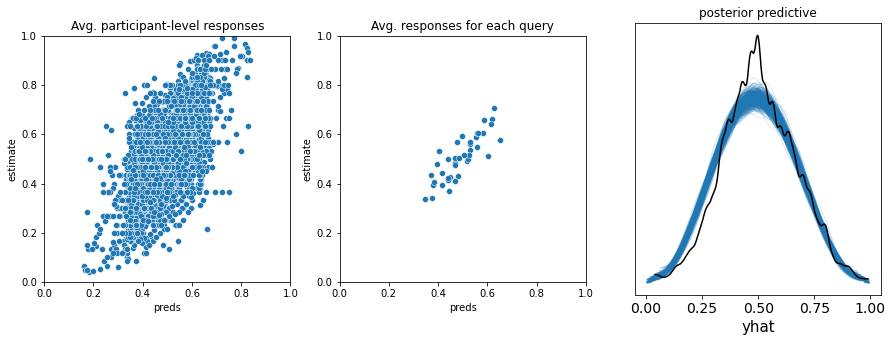

In [7]:
az_data_bs_mlm_simple = make_arviz_data(mcmc_bs_mlm_simple, bayesian_sampler_simple_mlm_d, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm_simple)

In [8]:
az.summary(az_data_bs_mlm_simple, var_names=['d_base_sd','d_base_pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,2.030,0.351,1.409,2.696,0.007,0.005,2695.0,3731.0,1.0
d_base_pop,3.988,0.410,3.249,4.786,0.006,0.004,5195.0,5507.0,1.0


## Complex

In [10]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm_d, target_accept_prob=.95), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)
# 
mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.675
Query-level corr 0.852


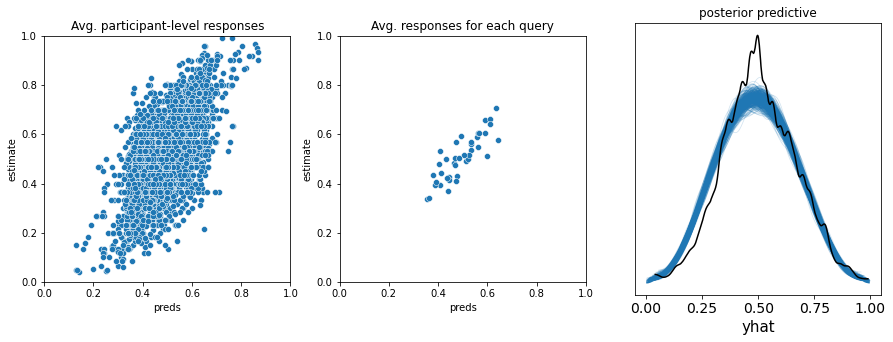

In [11]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm_d, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm)

In [13]:
az.summary(az_data_bs_mlm, var_names=['d_base_sd', 'd_delta_sd', 'd_delta_pop', 'd_base_pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.866,0.342,1.231,2.492,0.007,0.005,2401.0,4350.0,1.0
d_delta_sd,0.396,0.341,0.015,0.958,0.005,0.004,3638.0,5470.0,1.0
d_delta_pop,0.529,0.264,0.024,1.017,0.004,0.003,4408.0,4983.0,1.0
d_base_pop,3.023,0.399,2.283,3.756,0.007,0.005,3148.0,4679.0,1.0


# Hierarchical PT+N

## Simple

<!-- # Hierarchical PT+N -->


In [17]:
mcmc_ptn_mlm_simple = MCMC(NUTS(PTN_simple_mlm, target_accept_prob=.95), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_ptn_mlm_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.617
Query-level corr 0.772


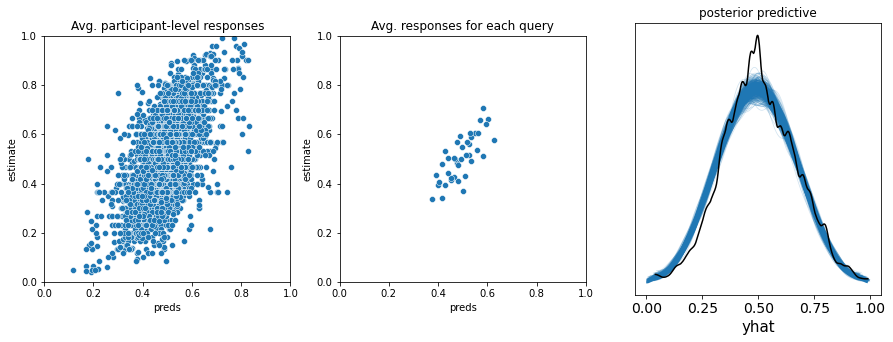

In [18]:
az_data_ptn_mlm_simple = make_arviz_data(mcmc_ptn_mlm_simple, PTN_simple_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm_simple)

## Complex

In [19]:
mcmc_ptn_mlm = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.95), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_ptn_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
# mcmc_ptn_mlm.print_summary()

Participant mean response corr =  0.658
Query-level corr 0.835


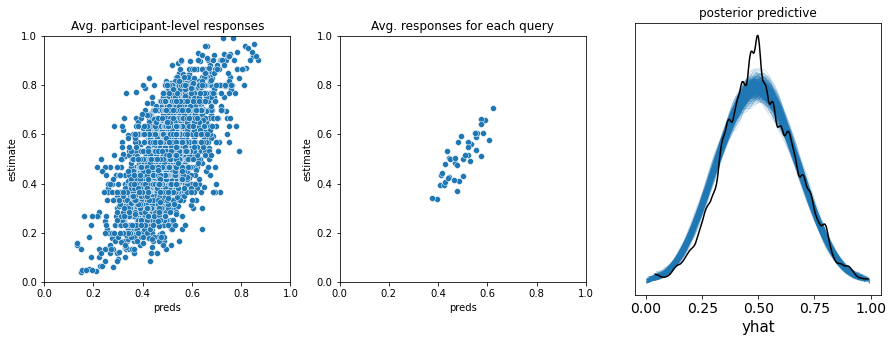

In [21]:
az_data_ptn_mlm = make_arviz_data(mcmc_ptn_mlm, PTN_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm)

## "Hybrid" —unconstrainted $\beta$ or PT+N without conditional probability account

In [23]:
# %run -i 'models.py'
mcmc_ptn_mlm_simplecond = MCMC(NUTS(PTN_complex_mlm_simplecond, target_accept_prob=.95), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_ptn_mlm_simplecond.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.688
Query-level corr 0.878


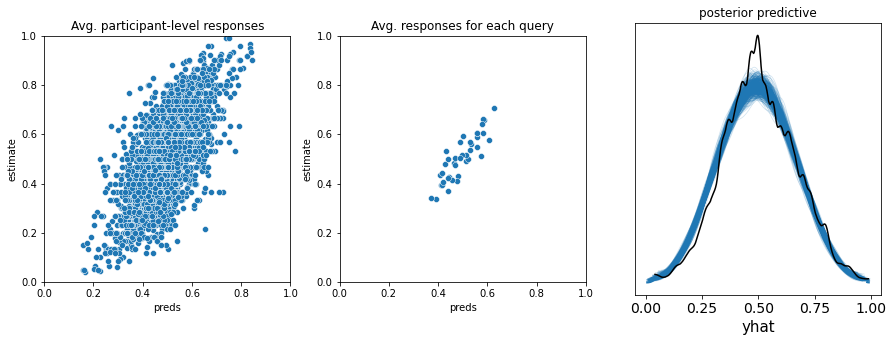

In [24]:
az_data_ptn_mlm_simplecond = make_arviz_data(mcmc_ptn_mlm_simplecond, PTN_complex_mlm_simplecond, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm_simplecond)

In [27]:
az.compare(
    {
        # "P+TN complex":az_data_ptn, 
        # "Bayesian Sampler complex": az_data_bs, 
        # "P+TN simple":az_data_ptn_simple, 
        # "Bayesian Sampler simple": az_data_bs_simple, 
        # "Relative Freq.":az_data_rf,
        "PTN_complex_mlm":az_data_ptn_mlm, 
        "PTN_simple_mlm":az_data_ptn_mlm_simple, 
        "BS_complex_mlm": az_data_bs_mlm,
        "BS_simple_mlm": az_data_bs_mlm_simple,
        "complex_hybrid": az_data_ptn_mlm_simplecond
    }, 
    scale="deviance", ic="loo", method="BB-pseudo-BMA")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
complex_hybrid,0,-3954.922446,367.890026,0.000000,1.000000e+00,86.097339,0.000000,True,deviance
BS_complex_mlm,1,-3815.403502,399.897568,139.518945,9.457071e-20,84.796429,22.670718,True,deviance
PTN_complex_mlm,2,-3796.898055,356.062858,158.024391,2.455811e-24,84.218603,21.382060,True,deviance
BS_simple_mlm,3,-3794.707245,381.027724,160.215201,1.967080e-21,84.263844,25.420278,True,deviance
PTN_simple_mlm,4,-3641.824390,306.362242,313.098056,6.382892e-47,84.496317,34.757791,False,deviance


Interesting that the restricted complex Bayesian Sampler has a higher penalty term than the unrestricted version. Otherwise the relative complexities seem roughly intuitive. ~~Maybe it has something to do with the $\theta$? Or maybe all the random effects are closer to zero when they aren't restricted?~~ I bet it is because the constraint on d and d' are encouraging pretty extreme values for the parameters on the linear scale, which is making that greater in terms of effective parameters.

Even though the models all seem relatively similar, there are pretty big differences in their predictive power! Comparing best to worse, there is about 17% more variance accounted for in condition means, and about 9% more in participant-level responses. 

# Comparing conditional probability judgments

Bayesian Sampler conditional response corr =  0.72
Bayesian Sampler conditional query-level corr 0.922


<AxesSubplot:xlabel='preds', ylabel='estimate'>

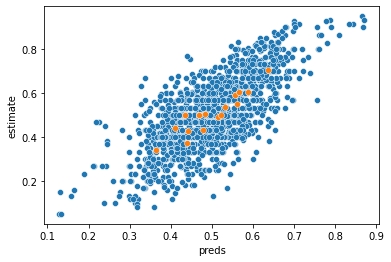

In [28]:
# zoom in on conditional trials

d = df
d["preds"] = az_data_bs_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],3))
sns.scatterplot(x = d.preds, y = d.estimate)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],3))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

PT+N conditional response corr =  0.67
PT+N conditional query-level corr 0.853


<AxesSubplot:xlabel='preds', ylabel='estimate'>

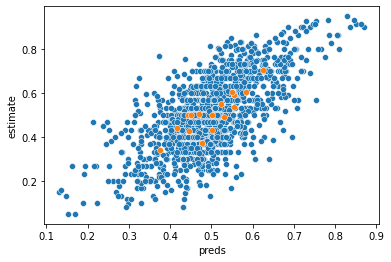

In [29]:
d = df
d["preds"] = az_data_ptn_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]

trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("PT+N conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],3))
sns.scatterplot(x = d.preds, y = d.estimate)
print("PT+N conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],3))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

Descriptively, the Bayesian Sampler does a better job predicting for conditional trials than does the PT+N model. That's consistent with the the diagnosis that the problem with the PT+N model is its account of conditional probability judgments, although the Bayesian sampler model is also showing a better correlation for non-conditional judgments. My guess there is the estimation of the PT+N model parameters are being biased by its incorrect specification for conditional probability trials.

# Summary of hierarchical models

If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then a hierarchical implementation of that model pulls ahead of a hierarchical implementation of PT+N. If you strip out the constructive account of conditional probability judgments from PT+N, then it is perhaps slightly better still, but it is not reliably distinguishable by $loo_{ic}$. The models are fundamentally equivalent at this point so any differences probably owe to implementation of the priors and internal parameterization of $d$ vs $N$.

If these results are to be trusted it's pretty decisive in favor of the Bayesian Sampler models account of conditional probability (these judgments are just like simple probability judgments) and therefore the Bayesian Sampler theory. As for whether we should appeal to "noise" or "priors", as Zhu and colleage's point out they are essentially indistinguishable at this point. Certain degrees of noise act like certain priors, and vice versa.

### A few concerns

* Am I inadvertantly putting a weird prior on d in the hierarchical models? — irrelevant to model comparison b/c they are equated

# Inspecting the models

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

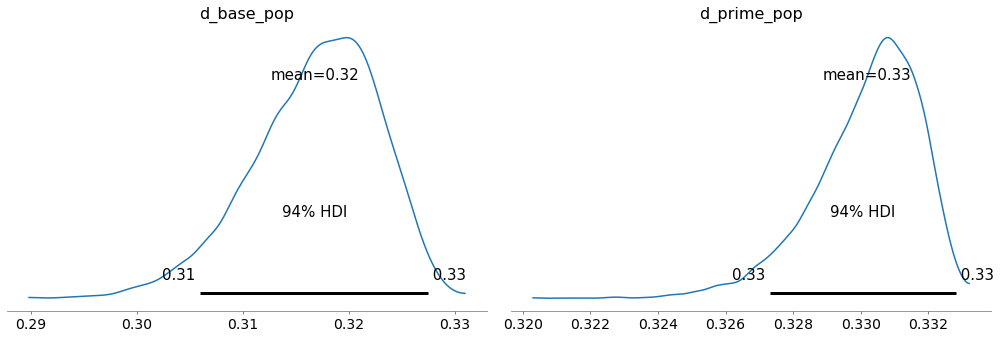

In [35]:
# az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_pop"], transform=np.exp)
# # az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_sd", "N_prime_sd", "N_delta_sd"], transform=np.exp)

# az_data_bs_mlm.posterior["N_base_pop"] = 1 + np.exp(az_data_bs_mlm.posterior.N_prime_pop) + np.exp(az_data_bs_mlm.posterior.N_delta_pop)
# az.plot_posterior(az_data_bs_mlm, var_names=["N_base_pop"])
# az.plot_posterior(az_data_bs_mlm, var_names=["N_prime_pop"], transform = lambda x: 1 + np.exp(x))

## Implied d
az_data_bs_mlm.posterior["d_prime_pop"] = az_data_bs_mlm.posterior.d_base_pop + np.exp(az_data_bs_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_bs_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/3.)


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

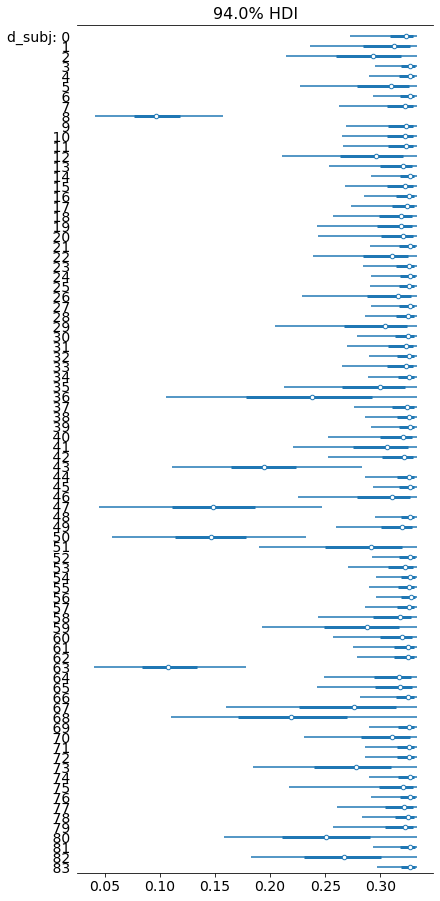

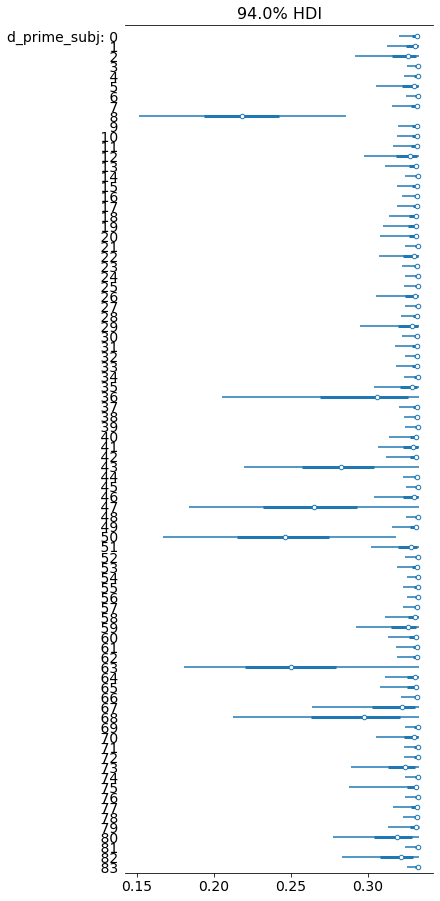

In [31]:
# az.plot_forest(data=az_data_bs_mlm, var_names=["beta_subj"],  combined=True)
# az.plot_forest(data=az_data_bs_mlm, var_names=["N_subj"], combined=True)
# az.plot_forest(data=az_data_bs_mlm, var_names=["N_prime_subj"], combined=True)

## implied d
az.plot_forest(data=az_data_bs_mlm, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["d_prime_subj"], combined=True)

In [93]:
print("num divergences =", count_divergences(az_data_bs_mlm))
az.summary(az_data_bs_mlm, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.884,0.335,1.307,2.541,0.009,0.007,1242.0,2123.0,1.00
d_delta_sd,0.390,0.295,0.038,0.899,0.049,0.035,33.0,90.0,1.13


In [94]:
print("num divergences =", count_divergences(az_data_ptn_mlm_simplecond))
az.summary(az_data_ptn_mlm_simplecond, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,0.812,0.101,0.631,1.013,0.003,0.002,1260.0,1887.0,1.00
d_delta_sd,0.211,0.117,0.042,0.416,0.022,0.016,28.0,176.0,1.13


In [95]:
print("num divergences =", count_divergences(az_data_ptn_mlm))
az.summary(az_data_ptn_mlm, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,0.992,0.127,0.746,1.219,0.004,0.003,1095.0,1935.0,1.01
d_delta_sd,0.192,0.108,0.024,0.385,0.020,0.014,29.0,38.0,1.11


Random effect stuff isn't sampling well. But it looks like it sort of explains why BS is more complex, has larger random effect SD.

## PT+N

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

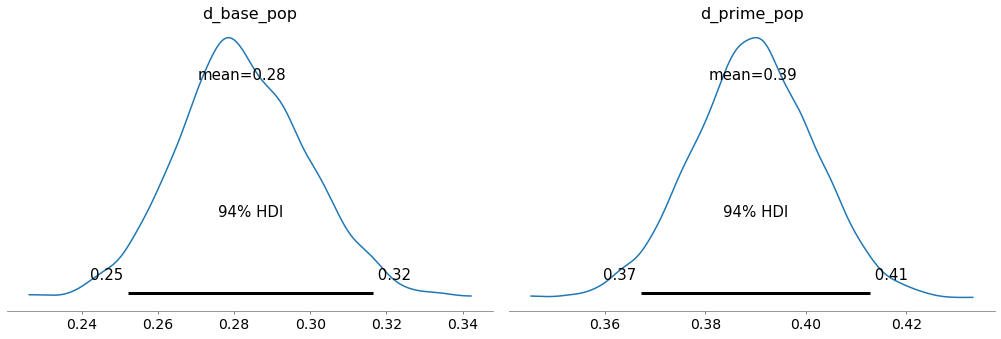

In [37]:
az_data_ptn_mlm.posterior["d_prime_pop"] = az_data_ptn_mlm.posterior.d_base_pop + np.exp(az_data_ptn_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_ptn_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

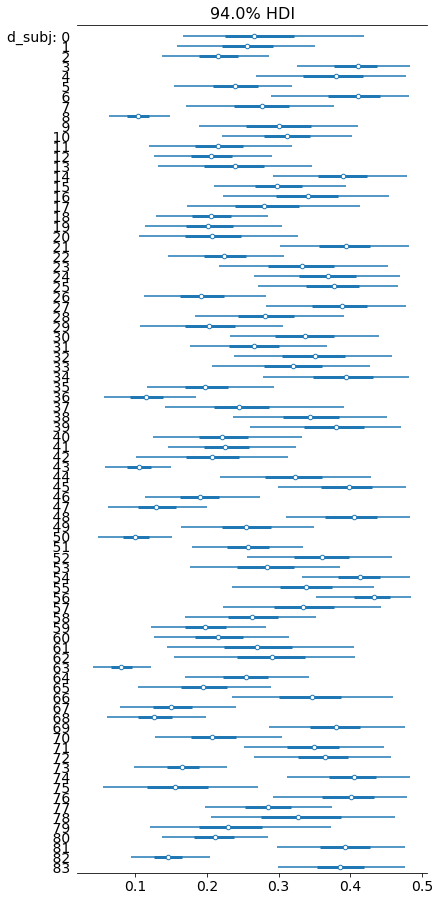

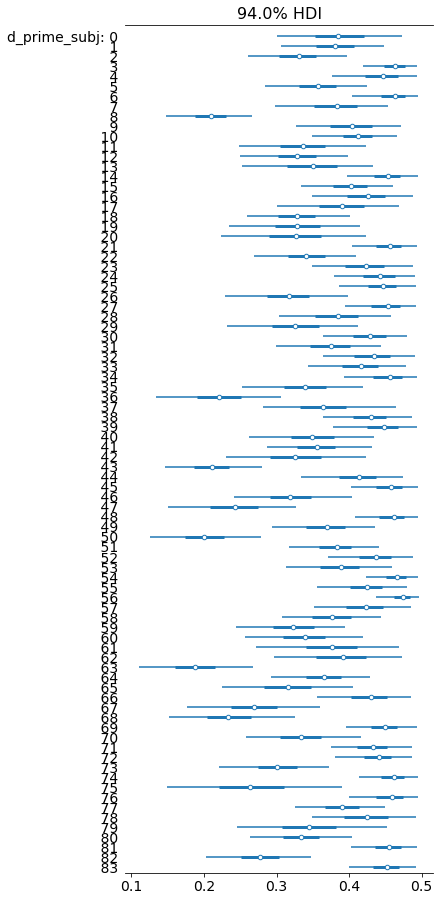

In [33]:
az.plot_forest(data=az_data_ptn_mlm, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_ptn_mlm, var_names=["d_prime_subj"], combined=True)

# Mixture models

## Bayesian Sampler multilevel + mixture model

This needs a bit of work to get it sampling properly. No divergences, but seeing some very bad $\hat{R}$s for some parameters and the $loo_{ic}$ warnings look somewhat serious.

In [85]:
mcmc_bs_mlm_mix = MCMC(NUTS(bayesian_sampler_complex_mlm_mix, target_accept_prob=.95), 
               num_warmup = 2_000, 
               num_samples = 2_000, 
               num_chains = 2)

mcmc_bs_mlm_mix.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [86]:
az_data_bs_mlm_mix = make_arviz_data(mcmc_bs_mlm_mix, bayesian_sampler_complex_mlm_mix, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs_mlm_mix))

num divergences = 0


Participant mean response corr =  0.688
Query-level corr 0.877


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pop,0.770,0.354,0.270,1.460,0.018,0.013,435.0,712.0,1.02
N_prime_pop,-1.741,1.488,-4.508,0.928,0.153,0.108,84.0,674.0,1.04
N_delta_pop,-0.197,0.459,-1.007,0.794,0.034,0.024,186.0,161.0,1.01
beta_sd,0.792,0.112,0.600,1.013,0.005,0.003,551.0,446.0,1.01
N_prime_sd,0.591,0.470,0.029,1.427,0.172,0.126,5.0,26.0,1.37
N_delta_sd,0.392,0.431,0.011,1.259,0.116,0.084,7.0,26.0,1.27
mixing[0],0.968,0.008,0.953,0.984,0.000,0.000,2902.0,1145.0,1.00
mixing[1],0.032,0.008,0.016,0.047,0.000,0.000,2902.0,1145.0,1.00


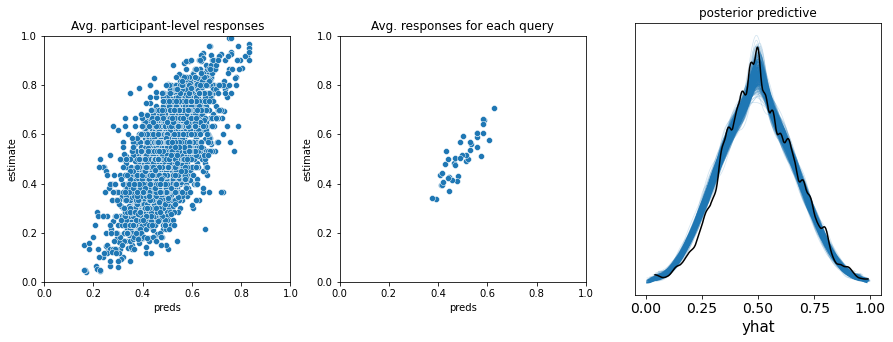

In [87]:
plot_model_preds(df, az_data_bs_mlm_mix)
main_vars = [ "beta_pop", "N_prime_pop", "N_delta_pop", "beta_sd", "N_prime_sd", "N_delta_sd", "mixing"]
az.summary(az_data_bs_mlm_mix2, var_names=main_vars)

## PT+N multilevel + mixture model

In [58]:
mcmc_ptn_mlm_mix = MCMC(NUTS(PTN_complex_mlm_mix, target_accept_prob=.95), 
               num_warmup = 2_000, 
               num_samples = 2_000, 
               num_chains = 2)

mcmc_ptn_mlm_mix.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

num divergences = 0
Participant mean response corr =  0.659
Query-level corr 0.836


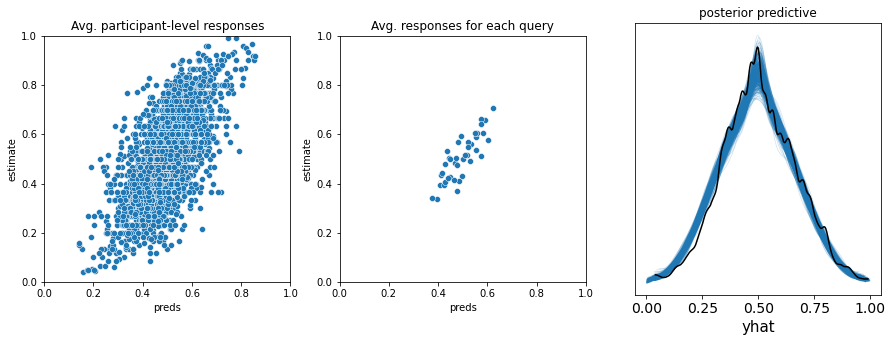

In [59]:
az_data_ptn_mlm_mix = make_arviz_data(mcmc_ptn_mlm_mix, PTN_complex_mlm_mix, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_ptn_mlm_mix))
plot_model_preds(df, az_data_ptn_mlm_mix)

compare all the models

In [80]:
az.compare(
    {
        "PTN_mlm":az_data_ptn_mlm, 
        "BS_mlm": az_data_bs_mlm,
        "PTN_mlm_mix":az_data_ptn_mlm_mix, 
        "BS_mlm_mix": az_data_bs_mlm_mix,
        "P+TN":az_data_ptn, 
        "Bayesian Sampler": az_data_bs, 
        "Relative Freq.":az_data_rf
    }, 
    scale="deviance", ic="loo", method="BB-pseudo-BMA")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
BS_mlm_mix,0,-3964.643349,369.620666,0.000000,NaN,76.861586,0.000000,True,deviance
BS_mlm,1,-3949.498708,373.591659,15.144641,NaN,75.364276,9.422240,True,deviance
Bayesian Sampler,2,-3881.005671,418.245612,83.637678,NaN,77.842149,17.777454,True,deviance
PTN_mlm_mix,3,-3809.894546,355.838029,154.748803,NaN,78.294240,20.898512,True,deviance
PTN_mlm,4,-3795.061786,355.915398,169.581563,NaN,75.575341,23.300450,True,deviance
P+TN,5,-3769.284205,397.915260,195.359143,NaN,76.335614,24.583248,True,deviance
Relative Freq.,6,-1283.211329,426.448951,2681.432019,0.0,91.167083,87.822562,True,deviance


In [88]:
az.loo(az_data_bs_mlm_mix, scale="deviance", pointwise=True)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3962.66    80.69
p_loo          370.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3291   97.9%
 (0.5, 0.7]   (ok)         61    1.8%
   (0.7, 1]   (bad)         7    0.2%
   (1, Inf)   (very bad)    1    0.0%

In [92]:
a_vec = jnp.stack([jnp.ones(10)*2, jnp.ones(10)*4, jnp.ones(10)*4], -1)
b_vec = jnp.stack([jnp.ones(10)*2, jnp.ones(10)*4, jnp.ones(10)*4], -1)
mixing_vec = jnp.stack([jnp.ones(10)*.5, jnp.ones(10)*.5, jnp.ones(10)*.5], -1)
MixtureBeta(a_vec, b_vec, mixing_vec).sample(random.PRNGKey(0))

DeviceArray([0.11877543, 0.5712513 , 0.94381255, 0.4864969 , 0.7263023 ,
             0.3707984 , 0.8475313 , 0.8362999 , 0.74998975, 0.75741285],            dtype=float32)

In [95]:
z = dist.Dirichlet(jnp.ones((3)))

# z.sample(random.PRNGKey(1))[0,:]
with numpyro.plate("whatever", 5):
    x = numpyro.sample("test", z, rng_key = random.PRNGKey(0))

    
MixtureBeta(a_vec, b_vec, x[[1,2,3,4,5,1,2,3,4,5],:,...]).sample(random.PRNGKey(0))

DeviceArray([0.5556874 , 0.5712513 , 0.94381255, 0.6299685 , 0.8138755 ,
             0.3707984 , 0.8475313 , 0.8362999 , 0.5848643 , 0.75741285],            dtype=float32)